### This project builds a CNN-based classifier for Rock–Paper–Scissors hand gestures using a standard image dataset. The model is evaluated on unseen test data and custom mobile images to assess real-world performance. Visual error analysis is used to examine misclassified samples and understand model limitations.

## 1. Clone GitHub Repo

In [ ]:
!rm -rf CNN-Hand-Gestures-RPS-Pytorch
!git clone https://github.com/AdnanZamanNiloy/CNN-Hand-Gestures-RPS-Pytorch.git

Cloning into 'CNN-Hand-Gestures-RPS-Pytorch'...
remote: Enumerating objects: 4851, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 4851 (delta 1), reused 7 (delta 1), pack-reused 4843 (from 3)
Receiving objects: 100% (4851/4851), 390.53 MiB | 45.19 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (4722/4722), done.


## 2. Verify

In [ ]:
import os
os.listdir("CNN-Hand-Gestures-RPS-Pytorch/dataset/phone")


['img1.png',
 'img10.png',
 'img3.png',
 'img4.png',
 'img12.png',
 'img13.png',
 'img7.png',
 'img5.png',
 'img2.png',
 'img8.png',
 'img11.png',
 'img9.png',
 'img6.png']

## 3. Import Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix




## 4. Device Configuration

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


## 5. Define Transforms (UPDATED & CORRECT)
### 5.1 Training Transform (WITH augmentation)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4
    ),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

### 5.2 Validation / Test / Phone Transform (NO augmentation)

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


## 6. Load Dataset & Create Train / Validation Split

In [ ]:
from torchvision import datasets
from torch.utils.data import ConcatDataset, random_split


dataset1 = datasets.ImageFolder(
    root="CNN-Hand-Gestures-RPS-Pytorch/dataset/train_dataset1",
    transform=train_transform
)

dataset2 = datasets.ImageFolder(
    root="CNN-Hand-Gestures-RPS-Pytorch/dataset/train_dataset2",
    transform=train_transform
)


full_dataset = ConcatDataset([dataset1, dataset2])


class_names = dataset1.classes
print("Classes:", class_names)


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size]
)


val_dataset.dataset.datasets[0].transform = test_transform
val_dataset.dataset.datasets[1].transform = test_transform

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))


Classes: ['paper', 'rock', 'scissors']
Train size: 3766
Validation size: 942


## 7. DataLoaders

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)


## 8. Define CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)




## 9. Initialize Model, Loss & Optimizer

In [ ]:
model = CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 10. Training Loop with validation

In [ ]:
epochs = 10
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(epochs):

    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / total)


    model.eval()
    v_loss, v_correct, v_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
            v_total += labels.size(0)

    val_loss.append(v_loss / len(val_loader))
    val_acc.append(v_correct / v_total)

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Acc: {train_acc[-1]:.4f} | "
        f"Val Acc: {val_acc[-1]:.4f}"
    )


Epoch [1/10] | Train Acc: 0.6410 | Val Acc: 0.8885
Epoch [2/10] | Train Acc: 0.9259 | Val Acc: 0.9586
Epoch [3/10] | Train Acc: 0.9692 | Val Acc: 0.9565
Epoch [4/10] | Train Acc: 0.9862 | Val Acc: 0.9766
Epoch [5/10] | Train Acc: 0.9873 | Val Acc: 0.9851
Epoch [6/10] | Train Acc: 0.9923 | Val Acc: 0.9777
Epoch [7/10] | Train Acc: 0.9894 | Val Acc: 0.9798
Epoch [8/10] | Train Acc: 0.9942 | Val Acc: 0.9862
Epoch [9/10] | Train Acc: 0.9915 | Val Acc: 0.9788
Epoch [10/10] | Train Acc: 0.9960 | Val Acc: 0.9809


## 11. Training Curves (Required Visual)

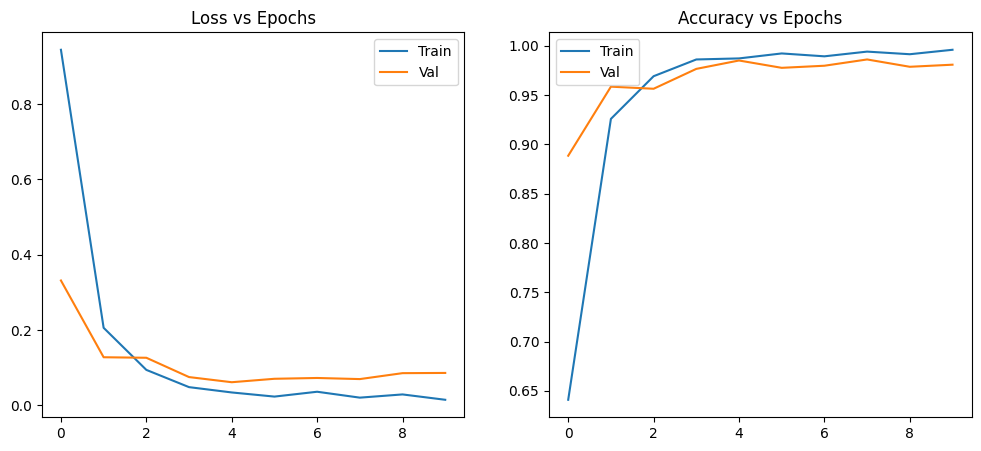

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Val")
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Val")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.show()


## 12. Save Model (.pth)

In [ ]:

os.makedirs("CNN-Hand-Gestures-RPS-Pytorch/model", exist_ok=True)
torch.save(model.state_dict(), "CNN-Hand-Gestures-RPS-Pytorch/model/rps_cnn.pth")


## 13. Confusion Matrix

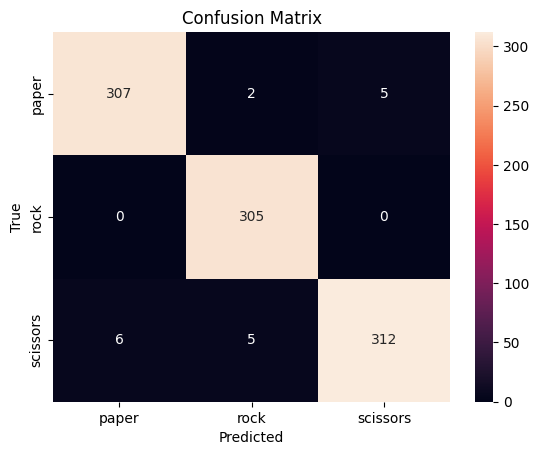

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## 14. Predict Phone Images (REAL-WORLD TEST)

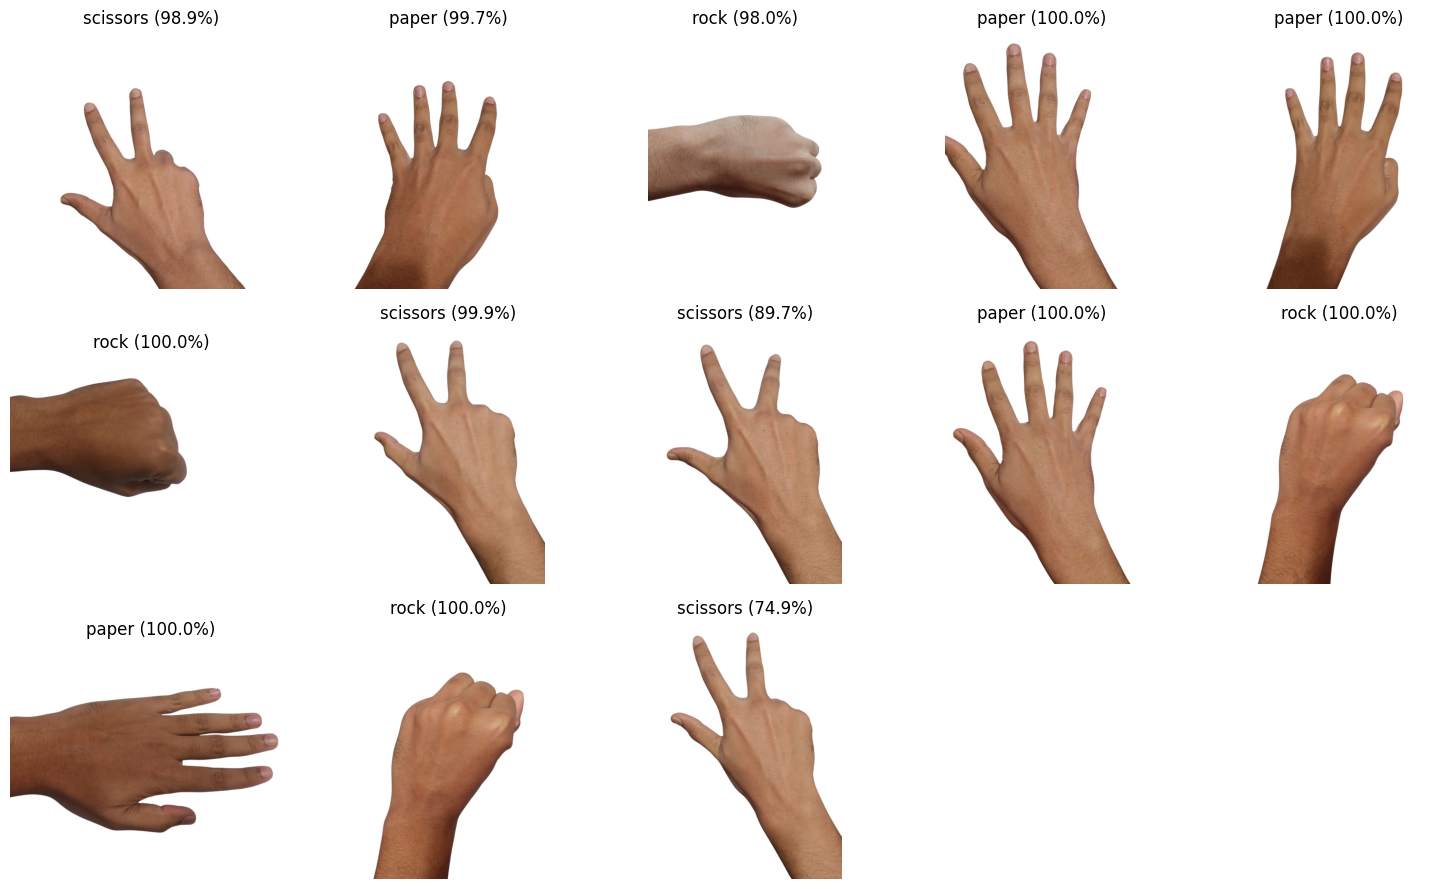

In [ ]:
import math
from PIL import Image

model.eval()

phone_dir = "CNN-Hand-Gestures-RPS-Pytorch/dataset/phone"
images = os.listdir(phone_dir)

num_images = len(images)
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 3, rows * 3))

for i, img_name in enumerate(images):
    img_path = os.path.join(phone_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    img_t = test_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        prob = torch.softmax(output, dim=1)
        conf, pred = torch.max(prob, 1)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{class_names[pred.item()]} ({conf.item()*100:.1f}%)")

plt.tight_layout()
plt.show()

# 15. Get 3 samples from training dataset

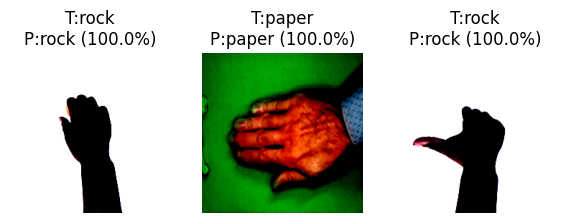

In [ ]:
model.eval()


num_samples = 3
indices = torch.randperm(len(train_dataset))[:num_samples]

plt.figure(figsize=(12,6))

for i, idx in enumerate(indices):
    img, true_label = train_dataset[idx]

    img_t = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        prob = torch.softmax(output, dim=1)
        conf, pred = torch.max(prob, 1)

    plt.subplot(2,5,i+1)
    plt.imshow(img.permute(1,2,0).cpu())
    plt.axis("off")
    plt.title(
        f"T:{class_names[true_label]}\n"
        f"P:{class_names[pred]} ({conf.item()*100:.1f}%)"
    )

plt.show()
